### COCO Dataset

The Microsoft Common Objects in COntext (MS COCO) dataset is a large-scale dataset for scene understanding. The dataset is commonly used to train and benchmark object detection, segmentation, and captioning algorithms.


**Step 1 - Loading the dataset using Coco API. It loads annotations and Instances of the images, along with there ID's.**

In [3]:
import os
import sys
sys.path.append('/Users/mayurjain/cocoapi/PythonAPI')
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = '/Users/mayurjain/cocoapi/'
dataType = 'train2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

annotation file  /Users/mayurjain/cocoapi/annotations/instances_train2014.json
loading annotations into memory...
Done (t=15.21s)
creating index...
index created!
annotation file  /Users/mayurjain/cocoapi/annotations/captions_train2014.json
loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


**Step 2 - Plot a Sample Image and its five annotations.**

Next, we plot a random image from the dataset, along with its five corresponding captions. Each time you run the code cell below, a different image is selected.

http://images.cocodataset.org/train2014/COCO_train2014_000000480818.jpg


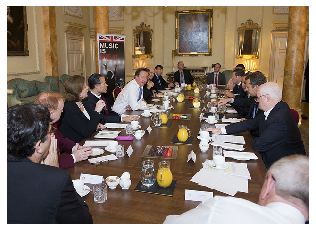

601143
A group of people sitting around a conference table.
A large group of people are at a meeting with breakfast refreshments.
Several people sitting at a large table with papers on it.
some men sitting aorund a long table with papers and drinks on it 
A bunch of people sitting at a very long table.


In [20]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids) # Randomly selects Image ID from ids. 
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

### Initialize the transform function for Images

In the code cell below, you will initialize the data loader by using the get_loader function in data_loader.py.

The get_loader function takes as input a number of arguments that can be explored in data_loader.py. Take the time to explore these arguments now by opening data_loader.py in a new window. Most of the arguments must be left at their default values. Some of the arguments you can try your hands on are below.

**How to create your own data_loader for your dataset:** http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

**transform** - an image transform specifying how to pre-process the images and convert them to PyTorch tensors before using them as input to the CNN encoder. For now, you are encouraged to keep the transform as provided in transform_train. You will have the opportunity later to choose your own image transform to pre-process the COCO images.

**mode** - one of 'train' (loads the training data in batches) or 'test' (for the test data). We will say that the data loader is in training or test mode, respectively. While following the instructions in this notebook, please keep the data loader in training mode by setting mode='train'.

**batch_size** - determines the batch size. When training the model, this is number of image-caption pairs used to amend the model weights in each training step.

**vocab_threshold** - the total number of times that a word must appear in the in the training captions before it is used as part of the vocabulary. Words that have fewer than vocab_threshold occurrences in the training captions are considered unknown words.

**vocab_from_file** - a Boolean that decides whether to load the vocabulary from file.

**tranforms.Normalize** - https://discuss.pytorch.org/t/understanding-transform-normalize/21730

**transforms** - https://stackoverflow.com/questions/50002543/what-are-transforms-in-pytorch-used-for

**vocab_from_file = False** - Since we don't have any existing vocabulary file we keep the argument as False, we need to generate a vocab file and store it. It is time consuming as it has to tokenize each caption mapped to the image. Once the file Vocab is created. The data loading using data loader will consume very less time and the argument is 'vocab_from_file' is turned to True.

In [5]:
import sys
sys.path.append('/Users/mayurjain/cocoapi/PythonAPI')
from pycocotools.coco import COCO
#!pip install nltk
import nltk
#nltk.download('punkt')
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

annotation file  /Users/mayurjain/cocoapi/annotations/captions_train2014.json
loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
[0/411490] Tokenizing captions...
[100000/411490] Tokenizing captions...
[200000/411490] Tokenizing captions...
[300000/411490] Tokenizing captions...
[400000/411490] Tokenizing captions...
annotation file  /Users/mayurjain/cocoapi/annotations/captions_train2014.json
loading annotations into memory...
Done (t=0.97s)
creating index...


  0%|          | 450/411490 [00:00<01:31, 4497.12it/s]

index created!
/Users/mayurjain/cocoapi/annotations/captions_train2014.json
Obtaining caption lengths...


100%|██████████| 411490/411490 [01:00<00:00, 6763.27it/s]


When you ran the code cell above, the data loader was stored in the variable data_loader.

You can access the corresponding dataset as data_loader.dataset.

### Exploring the __getitem__ Method

The __getitem__ method in the CoCoDataset class determines how an image-caption pair is pre-processed before being incorporated into a batch. 

When the data loader is in training mode, this method begins by first obtaining the filename (path) of a training image and its corresponding caption (caption).

In [6]:
# Sample Caption
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'

In [7]:
# Tokenize the caption
import nltk

sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']


In [8]:
"""There's a code in data_loader, where we convert word into index. For each caption, we append <start>
word and that word as index of 0. Simultaneously we also add <end> tag at each caption, which has index of 1.
"""
sample_caption = []

start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

Special start word: <start>
[0]


In [9]:
#Adding Caption to list.
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

[0, 3, 98, 750, 3, 393, 39, 3, 1004, 204, 133, 3, 749, 18]


In [10]:
#<end>
end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

Special end word: <end>
[0, 3, 98, 750, 3, 393, 39, 3, 1004, 204, 133, 3, 749, 18, 1]


In [11]:
import torch

sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

tensor([   0,    3,   98,  750,    3,  393,   39,    3, 1004,  204,  133,    3,
         749,   18,    1])


In [14]:
# Preview the word2idx dictionary.
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<start>': 0,
 '<end>': 1,
 '<unk>': 2,
 'a': 3,
 'very': 4,
 'clean': 5,
 'and': 6,
 'well': 7,
 'decorated': 8,
 'empty': 9}

In [15]:
#Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 8830


In [12]:
#Since we converting the word into index, there are some words which are not present in Vocab file. 
#These words are marked as <unk> and its index is 2. The value 8830 refers to all the word in captions.

unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

Special unknown word: <unk>
All unknown words are mapped to this integer: 2


In [13]:
print(data_loader.dataset.vocab('jfkafejw'))
print(data_loader.dataset.vocab('ieowoqjf'))

2
2


In [27]:
# Obtain the data loader (from file). Note that it runs much faster than before!
# data_loader = get_loader(transform=transform_train,
#                          mode='train',
#                          batch_size=batch_size,
#                          vocab_from_file=True)
print("Total Images in train2014: ", len(os.listdir(data_loader.dataset.img_folder)))

Total Images in train2014:  82259


In [28]:
from collections import Counter

total = 0
# Tally the total number of training captions with each length.
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    total = total + count
    print('value: %2d --- count: %5d' % (value, count))
    
print("Total Captions: ",total)

print("Approximately 5 captions for each image: ",len(os.listdir(data_loader.dataset.img_folder))*5)

value: 10 --- count: 85763
value: 11 --- count: 79453
value:  9 --- count: 71442
value: 12 --- count: 57282
value: 13 --- count: 37434
value: 14 --- count: 22202
value:  8 --- count: 20629
value: 15 --- count: 12775
value: 16 --- count:  7689
value: 17 --- count:  4809
value: 18 --- count:  3084
value: 19 --- count:  2001
value:  7 --- count:  1583
value: 20 --- count:  1443
value: 21 --- count:   993
value: 22 --- count:   678
value: 23 --- count:   531
value: 24 --- count:   379
value: 25 --- count:   276
value: 26 --- count:   212
value: 27 --- count:   155
value: 28 --- count:   112
value: 29 --- count:    86
value: 30 --- count:    58
value: 31 --- count:    49
value: 32 --- count:    44
value: 34 --- count:    39
value: 37 --- count:    32
value: 35 --- count:    31
value: 33 --- count:    30
value: 36 --- count:    26
value: 38 --- count:    18
value: 39 --- count:    18
value: 43 --- count:    16
value: 44 --- count:    16
value: 48 --- count:    12
value: 45 --- count:    11
v

In [30]:
import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length. we have taken a batch size of 10.
# So we are getting an 10 Image IDs + Caption IDs
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
# print('images:', images)
# print('captions:', captions)

sampled indices: [175895, 57857, 293521, 355679, 147323, 406843, 56702, 376036, 124604, 34046]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 12])


In [71]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

# Import EncoderCNN and DecoderRNN. 
from model import EncoderCNN, DecoderRNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
# Specify the dimensionality of the image embedding.
embed_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images (from Step 2) to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

torch.Size([10, 256])
type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


In [74]:
# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
#decoder.to(device)
    
# Move last batch of captions (from Step 1) to GPU if CUDA is available 
captions = captions.to(device)
print("Caption Shape: ",captions.shape)


# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)


# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

Hidden Size:  512
Initial LSTM Layers:  LSTM(256, 512, batch_first=True)
Linear Layer after LSTM:  LSTM(256, 512, batch_first=True)
Caption Shape:  torch.Size([10, 12])
Captions:  torch.Size([10, 12])
Caption Embedding Size:  torch.Size([10, 11, 256])
Features Unsqueeze:  torch.Size([10, 1, 256])
Image Features + Caption Embedding Size:  torch.Size([10, 12, 256])
Output Shape:  torch.Size([10, 12, 8830])
type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 12, 8830])


In [88]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/Users/mayurjain/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 128          # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = False    # if True, load existing vocab file
embed_size = 128           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 0.2             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function.
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
annotation file  /Users/mayurjain/cocoapi/annotations/captions_train2014.json
loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
[0/411490] Tokenizing captions...
[100000/411490] Tokenizing captions...
[200000/411490] Tokenizing captions...
[300000/411490] Tokenizing captions...
[400000/411490] Tokenizing captions...
annotation file  /Users/mayurjain/cocoapi/annotations/captions_train2014.json
loading annotations into memory...
Done (t=0.86s)
creating index...


  0%|          | 652/411490 [00:00<01:03, 6514.54it/s]

index created!
/Users/mayurjain/cocoapi/annotations/captions_train2014.json
Obtaining caption lengths...


100%|██████████| 411490/411490 [00:58<00:00, 6991.71it/s]


Hidden Size:  512
Initial LSTM Layers:  LSTM(128, 512, batch_first=True)
Linear Layer after LSTM:  LSTM(128, 512, batch_first=True)


**Perplexity:** https://jamesmccaffrey.wordpress.com/2016/08/16/what-is-machine-learning-perplexity/

**Epoch:** In each epoch, the model trains on all the records i.e. images here.

**Step:** In each step, a batch of 128 image + caption are taken and trained on. We have 3215 steps because 411490/128 would be ~3215 steps. During each step, the weights of the network are updated.

    https://stackoverflow.com/questions/38340311/what-is-the-difference-between-steps-and-epochs-in-tensorflow

**zero_grad():** https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

**embed_size:** The key point to notice is the embed size from the image and caption is 256 and it must remain same.

**order of steps to be taken:** https://discuss.pytorch.org/t/what-step-backward-and-zero-grad-do/33301

In [89]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

%load_ext autoreload
%autoreload 2
# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
for epoch in range(1, num_epochs+1):  
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()       
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))
        

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
        if i_step == 3:
            break
    
    break
    # Save the weights.
    #if epoch % save_every == 0:
        #torch.save(decoder.state_dict(), os.path.join('/Users/mayurjain/models', 'decoder-%d.pkl' % epoch))
        #torch.save(encoder.state_dict(), os.path.join('/Users/mayurjain/models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([128, 128])
Captions:  torch.Size([128, 13])
Caption Embedding Size:  torch.Size([128, 12, 128])
Features Unsqueeze:  torch.Size([128, 1, 128])
Image Features + Caption Embedding Size:  torch.Size([128, 13, 128])
Output Shape:  torch.Size([128, 13, 8830])
Epoch [1/3], Step [1/3215], Loss: 9.0906, Perplexity: 8871.0929torch.Size([128, 128])
Captions:  torch.Size([128, 14])
Caption Embedding Size:  torch.Size([128, 13, 128])
Features Unsqueeze:  torch.Size([128, 1, 128])
Image Features + Caption Embedding Size:  torch.Size([128, 14, 128])
Output Shape:  torch.Size([128, 14, 8830])
Epoch [1/3], Step [2/3215], Loss: 9.0044, Perplexity: 8138.6396torch.Size([128, 128])
Captions:  torch.Size([128, 13])
Caption Embedding Size:  torch.Size([128, 12, 128])
Features Unsqueeze:  torch.Size([128, 1, 128])
Image Features + Caption Embedding Size:  torch.Size([128, 13, 128])
Output Shape:  torch.Size([1

In [90]:
# Save the encoder and decoder state after training the model.
torch.save(decoder.state_dict(), os.path.join('/Users/mayurjain/models', 'decoder-1.pkl'))
torch.save(encoder.state_dict(), os.path.join('/Users/mayurjain/models', 'encoder-1.pkl'))

In [148]:
# Watch for any changes in model.py, and re-load it automatically.

#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_image = "/Users/mayurjain/Desktop/cv_images/COCO_test2014_000000000870.jpg"

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
# encoder = EncoderCNN(embed_size)
# encoder.eval()
# decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
# decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('/Users/mayurjain/model_basic/', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('/Users/mayurjain/model_basic/', decoder_file)))

# # Move models to GPU if CUDA is available.
# encoder.to(device)
# decoder.to(device)

<All keys matched successfully>

torch.Size([1, 256])
lstm output shape  torch.Size([1, 1, 512])
lstm output.squeeze(1) shape  torch.Size([1, 512])
linear output shape  torch.Size([1, 8830])
target_index shape  torch.Size([1])
new inputs shape  torch.Size([1, 1, 256]) 

lstm output shape  torch.Size([1, 1, 512])
lstm output.squeeze(1) shape  torch.Size([1, 512])
linear output shape  torch.Size([1, 8830])
target_index shape  torch.Size([1])
new inputs shape  torch.Size([1, 1, 256]) 

lstm output shape  torch.Size([1, 1, 512])
lstm output.squeeze(1) shape  torch.Size([1, 512])
linear output shape  torch.Size([1, 8830])
target_index shape  torch.Size([1])
new inputs shape  torch.Size([1, 1, 256]) 

lstm output shape  torch.Size([1, 1, 512])
lstm output.squeeze(1) shape  torch.Size([1, 512])
linear output shape  torch.Size([1, 8830])
target_index shape  torch.Size([1])
new inputs shape  torch.Size([1, 1, 256]) 

lstm output shape  torch.Size([1, 1, 512])
lstm output.squeeze(1) shape  torch.Size([1, 512])
linear output sha

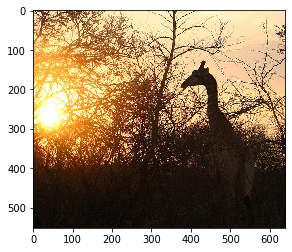

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

# Convert image to tensor and pre-process using transform
image = Image.open(sample_image).convert('RGB')
trans_img = transform_train(image)
trans_img = trans_img[np.newaxis,:]

# Obtain the embedded image features.
features = encoder(trans_img).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)
plt.imshow(image)
assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

In [150]:
def clean_sentence(output):
    sentense = ''
    for i in output:
        word = data_loader.dataset.vocab.idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentense = sentense + word
        else:
            sentense = sentense + ' ' + word
    
    return sentense.strip()

In [151]:
sentence = clean_sentence(output)
print(sentence)

a giraffe is standing in a field with trees in the background.
